# Text Classification

This notebook implements text classification of sentiments using guidedlda topic vectors

## Imports

In [1]:
# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")


# Data manipulation 
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Topic modeling
import guidedlda

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model selection and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [123]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load and examine the data

In [3]:
df = pd.read_csv('../data/sentence.csv') 
df.head()

,sentence,company,sentiment
0,I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8647
1,Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481
2,I must note that I had also received 2 previou...,Walmart MASTERCARD,0.8225
3,After 6 weeks and a few major purchases I was ...,Walmart MASTERCARD,0.7943
4,I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845


In [4]:
df.shape

(111357, 3)

## Sentiment categorization

In [5]:
df = df[df.sentiment != 0] # Remove neutral reviews

In [14]:
df['positivity'] = np.where(df.sentiment >= 0.4,1,0 ) # Positivity score based on sentiments

In [15]:
(df['positivity'].value_counts()/len(df))*100

1    51.941315
0    48.058685
Name: positivity, dtype: float64

## Topic modeling using GuidedLDA

In [16]:
bows, vocab, word2id, vectorizer = doc_term_matrix(df, 'sentence')

In [27]:
bows.shape

(84247, 10964)

In [69]:
# Guided LDA with seeded topics.
seed_topic_list = [['online', 'app','website','apply', 'approve', 'online', 'offer', 'application'],
                    ['customer','service','good', 'great', 'helpful', 'love', 'help', 'excellent'],
                   [ 'payment', 'fee', 'charge', 'late', 'month', 'due', 'score'],
                    ['close', 'cancel',  'closure', 'charge'],
                    ['high', 'interest', 'rate',  'apr', 'annual', 'fee', 'yearly', 'limit'],
                    ['recommend','good', 'love','like', 'great'],
                    ['fraud', 'fraudulent','scam', 'terrible'],
                    ['reward', 'point','cash', 'back', 'purchase','good', 'love'], 
                    ['mile', 'travel', 'point', 'airline', 'good', 'love'],
                    ['build', 'rebuild', 'limit']]
                    
model = guidedlda.GuidedLDA(n_topics=16, n_iter=1000, random_state=7, refresh=20)

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
model.fit(bows, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 84247
INFO:guidedlda:vocab_size: 10964
INFO:guidedlda:n_words: 443047
INFO:guidedlda:n_topics: 16
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -5438099
INFO:guidedlda:<20> log likelihood: -3373310
INFO:guidedlda:<40> log likelihood: -3274107
INFO:guidedlda:<60> log likelihood: -3226344
INFO:guidedlda:<80> log likelihood: -3198955
INFO:guidedlda:<100> log likelihood: -3182608
INFO:guidedlda:<120> log likelihood: -3170391
INFO:guidedlda:<140> log likelihood: -3161967
INFO:guidedlda:<160> log likelihood: -3155282
INFO:guidedlda:<180> log likelihood: -3151137
INFO:guidedlda:<200> log likelihood: -3146775
INFO:guidedlda:<220> log likelihood: -3143587
INFO:guidedlda:<240> log likelihood: -3140875
INFO:guidedlda:<260> log likelihood: -3138314
INFO:guidedlda:<280> log likelihood: -3136549
INFO:guidedlda:<300> log likelihood: -3136426
INFO:guidedlda:<320> log likelihood: -3133894
INFO:guidedlda:<340> log likelihood: -3132928
INFO:guidedlda:<360> log

In [70]:
n_top_words =10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: app online payment love website like bill great check balance
Topic 1: service customer great good helpful problem excellent issue experience love
Topic 2: fee payment charge late month balance interest paid due bill
Topic 3: charge payment purchase fraud approve cancel fraudulent apply email week
Topic 4: interest rate fee high annual low balance great month apr
Topic 5: recommend great good anyone highly definitely accepted friend help everywhere
Topic 6: payment security address mail phone information support check letter state
Topic 7: cash back reward purchase love great like earn point gas
Topic 8: point travel reward fee great love like mile purchase earn
Topic 9: limit increase score help year good payment month build start
Topic 10: customer service phone speak help talk supervisor rep person cancel
Topic 11: report year close problem score cancel charge issue customer help
Topic 12: reward year cash month back offer bonus first point purchase
Topic 13: love great goo

In [71]:
model_topics = ['topic{}'.format(i) for i in range(model.components_.shape[0])]
components = pd.DataFrame(model.components_.T, index=vocab, columns = model_topics)

In [72]:
components.topic4.sort_values(ascending = False)[:10]

interest    0.091533
rate        0.074831
fee         0.060904
high        0.041547
annual      0.032252
low         0.032045
balance     0.027265
great       0.019888
month       0.019387
apr         0.017823
Name: topic4, dtype: float64

## Extract  topic vector

In [73]:
doc_topic = model.transform(bows)

In [82]:
columns16 = ['topic{}'.format(i) for i in range(16)]
topic_vector = pd.DataFrame(doc_topic, columns = columns16)
topic_vector.round(2).head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
0,0.00,0.00,0.84,0.00,0.15,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00
1,0.01,0.01,0.00,0.00,0.00,0.0,0.00,0.96,0.01,0.00,0.0,0.0,0.0,0.0,0.00,0.01
2,0.00,0.08,0.00,0.04,0.00,0.0,0.19,0.00,0.00,0.34,0.0,0.0,0.0,0.0,0.34,0.00
3,0.00,0.00,0.38,0.15,0.00,0.0,0.00,0.00,0.00,0.43,0.0,0.0,0.0,0.0,0.00,0.02
4,0.00,0.11,0.39,0.37,0.00,0.0,0.02,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.10


In [112]:
topic_vector.shape

(84247, 16)

## Create a test set

In [113]:
X = topic_vector # Feature matrix
y = df.positivity # class variable

Split into 80% training set and 20% test set using stratify sampling

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, stratify = y, random_state = 42)

In [78]:
print('Training set size:', X_train.shape)
print('Training set class size:', y_train.shape)
print('Test set size:', X_test.shape)
print('Test set class size:', y_test.shape)

Training set size: (67397, 16)
Training set class size: (67397,)
Test set size: (16850, 16)
Test set class size: (16850,)


## Model selection by cross-validation

In [95]:
models = []

models.append(('nb_clf',  MultinomialNB()))
models.append(('lr_clf',  LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')))
models.append(('rf_clf',  RandomForestClassifier(random_state = 42)))

cv_score = []
names = []
y_train_preds = []

for name, model in models:
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'accuracy')
    y_train_pred = cross_val_predict(model, X_train, y_train, cv = 10)
    cv_score.append(score)
    names.append(name)
    y_train_preds.append(y_train_pred)
    
    print('%s: %f(%f)'%(name, score.mean(), score.std()))
    print('Predicted classes:', np.unique(y_train_pred))
    print('Confusion matrix:\n', confusion_matrix(y_train, y_train_pred))
    print('Classification report:\n', classification_report(y_train, y_train_pred))
    print('*********************************************************')  

nb_clf: 0.726427(0.007010)
Predicted classes: [0 1]
Confusion matrix:
 [[21344 11046]
 [ 7392 27615]]
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.70     32390
           1       0.71      0.79      0.75     35007

    accuracy                           0.73     67397
   macro avg       0.73      0.72      0.72     67397
weighted avg       0.73      0.73      0.73     67397

*********************************************************
lr_clf: 0.729513(0.007150)
Predicted classes: [0 1]
Confusion matrix:
 [[21895 10495]
 [ 7735 27272]]
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.68      0.71     32390
           1       0.72      0.78      0.75     35007

    accuracy                           0.73     67397
   macro avg       0.73      0.73      0.73     67397
weighted avg       0.73      0.73      0.73     67397

************************************

Text(0, 0.5, 'Cross validation accuracy')

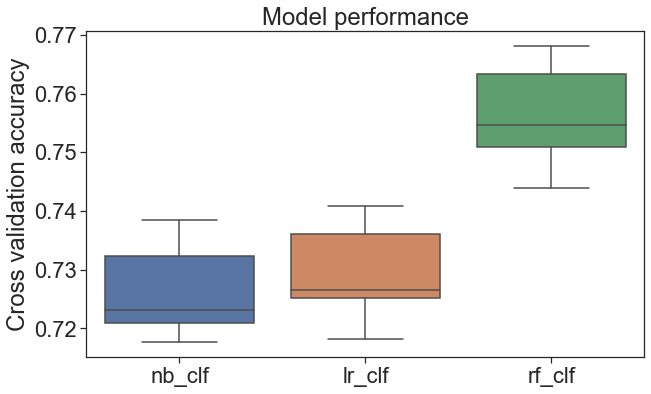

In [96]:
plt.figure(figsize = (10,6))
sns.set(font_scale = 2)
sns.set_style('ticks')

# Display box plots
sns.boxplot(x = names, y = cv_score)
plt.title('Model performance')
plt.ylabel('Cross validation accuracy')

# Hyperparameter Tuning

## Logistic regression classifier

In [103]:
# Range of hyperparameters
param_grid = {'C': [2**(-3), 2**(-2), 2**(-1), 2**(0)]}
                             
# Grid search for LR
gsearch_lr = GridSearchCV(LogisticRegression(),param_grid, cv = 10, scoring = 'accuracy',n_jobs = -1,
                          verbose =1)
                                
# Fit the training set
gsearch_lr.fit(X_train, y_train)

print('Grid search best score: ', gsearch_lr.best_score_)
print('Grid search best hyperparameters: ', gsearch_lr.best_params_)    

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.7s finished


Grid search best score:  0.7295131830793655
Grid search best hyperparameters:  {'C': 0.5}


## Random forest classifier

In [105]:
# Range of hyperparameters
params = {'max_features': [1,0.5,'sqrt','log2'], 'min_samples_leaf': [1,3,5,10]}

# Grid search
rf =  RandomForestClassifier(n_estimators = 200, random_state = 42)
gsearch_rf = GridSearchCV(estimator = rf, param_grid = params, scoring = 'accuracy', 
                          cv = 10, n_jobs = -1, verbose = 1)                           
# Fit the training set                                                 
gsearch_rf.fit(X_train, y_train)

print('Grid search best score:', gsearch_rf.best_score_) 
print('Grid search best hyperparameters:', gsearch_rf.best_params_) 

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 62.8min finished




Grid search best score: 0.7796192708874282
Grid search best hyperparameters: {'max_features': 'sqrt', 'min_samples_leaf': 1}


## Feature importance

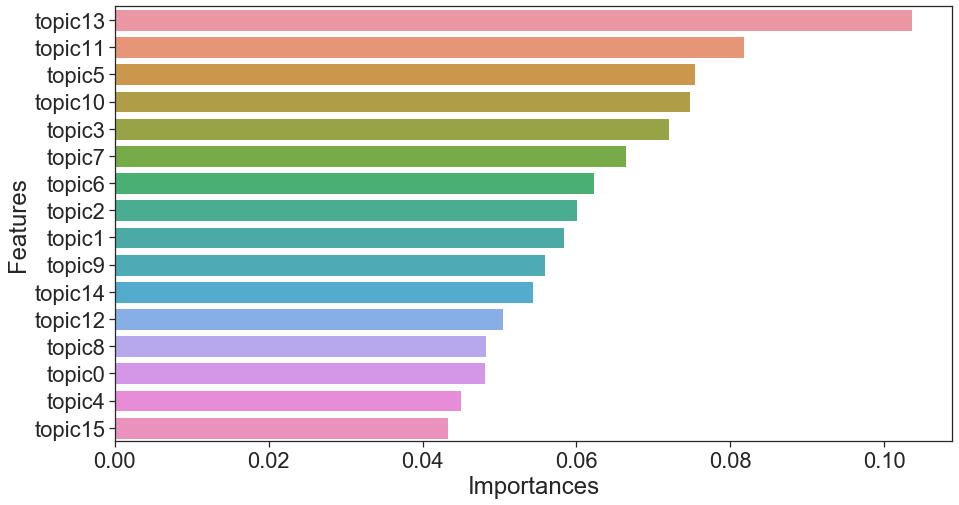

In [121]:
# Feature importance
features = X_train_prepared.columns
importances = rsearch_rf.best_estimator_.feature_importances_
importance_df = pd.DataFrame({'Features': features, 'Importances': importances})
importance_df = importance_df.sort_values('Importances', ascending=False)

# Bar plot
plt.figure(figsize = (15,8))
sns.barplot(data = importance_df,  x = 'Importances', y = 'Features')

##  ROC and PR curves for the cross-validation Training Set

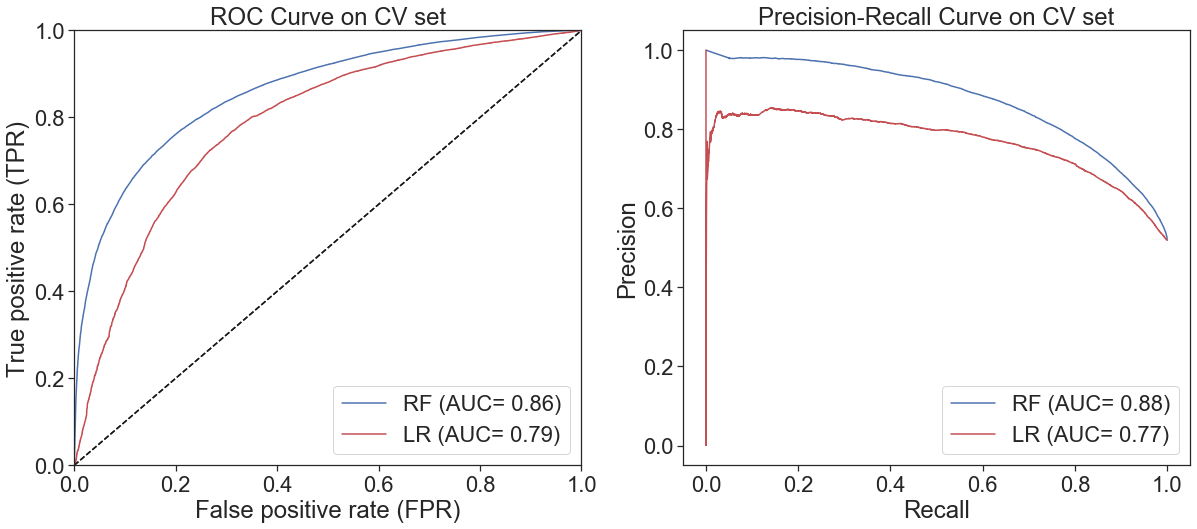

In [118]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})

# Plot ROC and PR curves for Random Forest
Plot_ROC_Curve_and_PRC_Cross_Val(gsearch_rf.best_estimator_, X_train, y_train,
                       color= 'b', label = 'RF (AUC= %0.2f)')

# Plot ROC and PR curves for Logistic Regression
Plot_ROC_Curve_and_PRC_Cross_Val(gsearch_lr.best_estimator_, X_train, y_train,
                       color= 'r', label = 'LR (AUC= %0.2f)')

# Prediction on the  Test Set

## Random forest classifier

In [124]:
Test_Prediction(gsearch_rf.best_estimator_, X_train, y_train, X_test, y_test)

****************************************************************************
Test accuracy:  0.777685
AUROC: 0.859733
AUPRC: 0.875321
Predicted classes: [0 1]
Confusion matrix:
 [[6423 1675]
 [2071 6681]]
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77      8098
           1       0.80      0.76      0.78      8752

    accuracy                           0.78     16850
   macro avg       0.78      0.78      0.78     16850
weighted avg       0.78      0.78      0.78     16850

****************************************************************************


## Logistic regression classifier

In [125]:
Test_Prediction(gsearch_lr.best_estimator_, X_train, y_train, X_test, y_test)

****************************************************************************
Test accuracy:  0.727478
AUROC: 0.786639
AUPRC: 0.768643
Predicted classes: [0 1]
Confusion matrix:
 [[5426 2672]
 [1920 6832]]
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.70      8098
           1       0.72      0.78      0.75      8752

    accuracy                           0.73     16850
   macro avg       0.73      0.73      0.73     16850
weighted avg       0.73      0.73      0.73     16850

****************************************************************************


## ROC and PR Curves on the Test Set

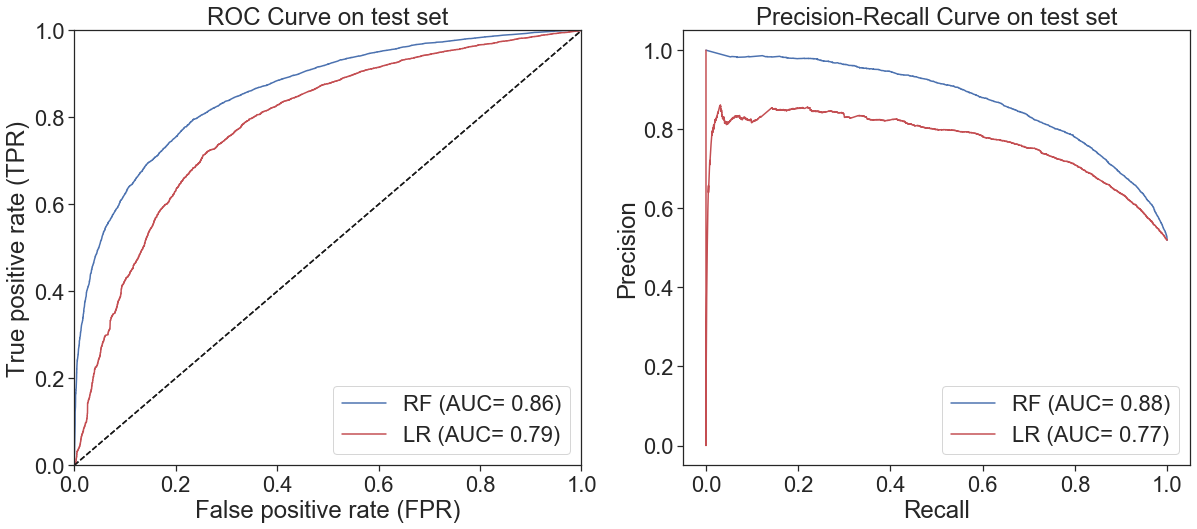

In [127]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})

# Plot ROC and PR curves for Random Forest
Plot_ROC_Curve_and_PRC(gsearch_rf.best_estimator_, X_train, y_train, X_test, y_test,
                       color= 'b', label = 'RF (AUC= %0.2f)')

# Plot ROC and PR curves for Logistic Regression
Plot_ROC_Curve_and_PRC(gsearch_lr.best_estimator_, X_train, y_train, X_test, y_test,
                       color= 'r', label = 'LR (AUC= %0.2f)')